# **Image Classification using Keras**

## Importing Libraries

In [ ]:
import tensorflow as tf
import os  #The OS module in python provides functions for interacting with the operating system.
#OS, comes under Python’s standard utility modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')            #if models folder not present,make one....
    
print('TensorFlow version:', tf.__version__)


TensorFlow version: 2.2.0


## Pre-Process Data

In [ ]:
def get_three_classes(x, y):
    
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))  #get indices where y==class_id... i.e get indices 0,1 & 2 
        return indices
# We have taken only 3 indices since data is big.

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False) #generates a random sample 
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)   #Converts a class vector (integers) to binary class matrix
    
    return x, y

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() #downloading cifar10 dataset using keras dataset

x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


NOTE: x_train and y_train has 15,000 samples for training. x_test and y_test has 3000 samples for testing.

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

In [ ]:
class_names = ['aeroplane', 'car', 'bird']  

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(12, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)  #(no of rows,no. of cols,index)
        plt.imshow(x[i])  #display images
        plt.xticks([])  # no x ticks
        plt.yticks([])  #no y ticks
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'  # if predicted correctly shows text in green else in red
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()



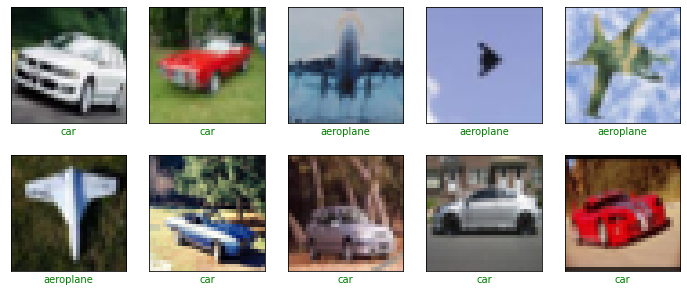

In [ ]:
show_random_examples(x_train, y_train, y_train)  #random images off of training set

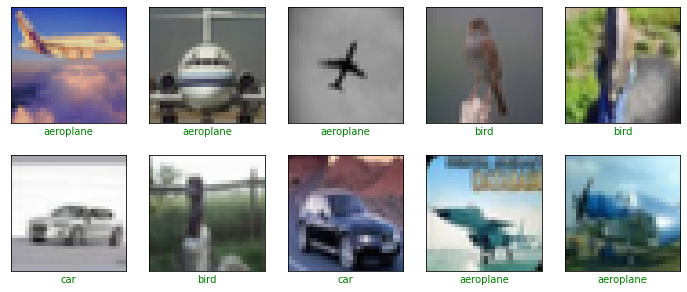

In [ ]:
show_random_examples(x_test, y_test, y_test) #random images off of test set

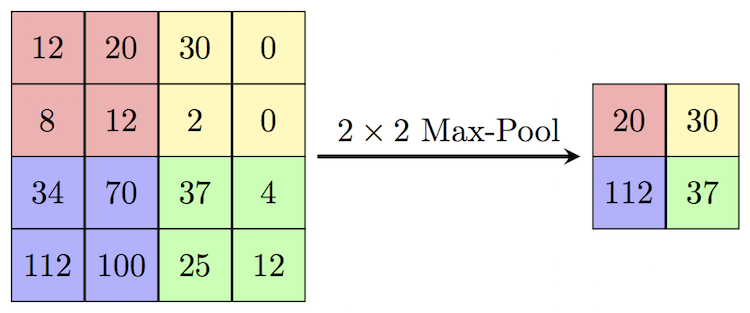

Took the image from google to understand about pooling clearly

## **Model Creation**

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    
    def add_conv_block(model, num_filters):  #function to add layers for CNN model
    
        model.add(Conv2D(num_filters, kernel_size= 3, activation='relu', padding='same'))#num_filters=the number of output filters in the convolution
        model.add(BatchNormalization())#Normalize the activations of the previous layer at each batch,i.e. applies a transformation.
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))#kernel_size=(3,3)
        model.add(MaxPooling2D(pool_size=2))
        #Max pooling is a sample-based discretization process. The objective is to down-sample an input representation, reducing its dimensionality and allowing for assumptions to be made about features.
        model.add(Dropout(0.2))
        #Dropout is done to avoid overfitting in Neural network

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))  #CNN takes input of tensors of shape (image_height, image_width, color_channels)
    
    model = add_conv_block(model, 32)  #32=num_filters -->filters
    model = add_conv_block(model, 64)    #Filters are used to extract features from images in the process of convolution
    model = add_conv_block(model, 128)
    #When you use filters=128 and kernel_size=3, you are creating 128 different filters, each of them with length 3. 
    #The result will bring 128 different convolutions.

    model.add(Flatten()) #used to get a copy of given array collapsed into one dimension.
    model.add(Dense(3,activation='softmax')) #3 indicates no of neurons in output layer....since we have 3 categories[aeroplane,car,ship] # Dense NN

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #compiling the model
    return model

model = create_model()  #function call
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

## `Train the model`

In [ ]:
model_fit = model.fit(
    x_train/255., y_train,   #/255 since its rgb image
    validation_data=(x_test/255., y_test),  #Data on which to evaluate the loss and any model metrics at the end of each epoch.
    epochs=20, batch_size=256,#The batch_size defines the number of samples that will be propagated through the network.
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)

Epoch 1/20
59/59 [==============================] - 75s 1s/step - loss: 0.3719 - accuracy: 0.8549 - val_loss: 2.0262 - val_accuracy: 0.3950
Epoch 2/20
59/59 [==============================] - 75s 1s/step - loss: 0.3205 - accuracy: 0.8780 - val_loss: 1.9268 - val_accuracy: 0.3560
Epoch 3/20
59/59 [==============================] - 75s 1s/step - loss: 0.2777 - accuracy: 0.8952 - val_loss: 1.8861 - val_accuracy: 0.4053
Epoch 4/20
59/59 [==============================] - 75s 1s/step - loss: 0.2466 - accuracy: 0.9052 - val_loss: 1.5543 - val_accuracy: 0.3440
Epoch 5/20
59/59 [==============================] - 75s 1s/step - loss: 0.2316 - accuracy: 0.9104 - val_loss: 1.2878 - val_accuracy: 0.5700
Epoch 6/20
59/59 [==============================] - 75s 1s/step - loss: 0.2068 - accuracy: 0.9216 - val_loss: 0.8306 - val_accuracy: 0.6940
Epoch 7/20
59/59 [==============================] - 75s 1s/step - loss: 0.1921 - accuracy: 0.9264 - val_loss: 0.4073 - val_accuracy: 0.8427
Epoch 8/20
59/59 [==

**NOTE:** ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

## Predictions on Trained Model

In [ ]:
model_new = tf.keras.models.load_model('models/model_0.928.h5')

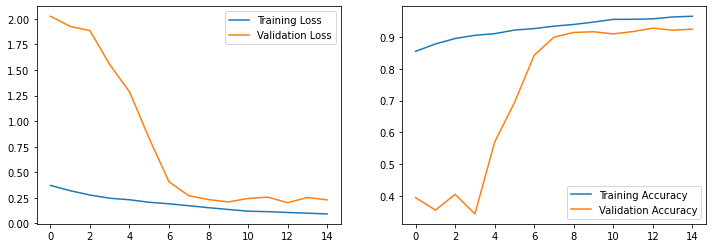

In [ ]:
losses = model_fit.history['loss']
accs = model_fit.history['accuracy']
val_losses = model_fit.history['val_loss']
val_accs = model_fit.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
prediction = model_new.predict(x_test/255.)

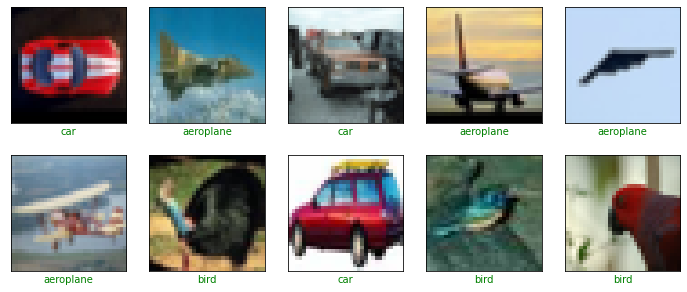

In [ ]:
show_random_examples(x_test, y_test, prediction)